# Test analysis

### Import libraries

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
import pandas as pd
import dask
# from mpl_toolkits.basemap import Basemap
# from datetime import datetime
# from datetime import timedelta
# from scipy import stats
# import scipy.interpolate as interp
# from dask.distributed import Client
%matplotlib inline

In [2]:
from functions import ccplot, binning

In [48]:
import seaborn as sns
# Use seaborn style defaults and set default figure size
# plt.style.use('seaborn-pastel')
# sns.set_theme(style="ticks")
plt.style.use(['science', 'notebook'])

In [4]:
# Colormap selection
xr.set_options(cmap_divergent='RdBu_r', cmap_sequential='YlGnBu')

### Import data

In [12]:
mfdata_DIR = './data/GPM_lowres_data/gpm_200*.nc'

gpm = xr.open_mfdataset(mfdata_DIR, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_mfdataset(mfdata_DIR, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# gpm = xr.open_dataset('./data/GPM_data/gpm_2000.nc', chunks={"time":2000})

In [13]:
gpm.unify_chunks()
gpm.chunks

Frozen({'time': (5000, 5000, 272, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2568, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2520, 5000, 5000, 5000, 2568, 5000, 5000, 5000, 2520), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [14]:
gpm

,Array,Chunk
Bytes,16.23 GiB,30.52 MiB
Shape,"(168048, 161, 161)","(5000, 40, 40)"
Count,1960 Tasks,975 Chunks
Type,float32,numpy.ndarray


In [15]:
precip = gpm.precipCal.resample(time = '1H').mean()

In [16]:
precip = precip.chunk(dict(time=5000, lat=40, lon=40))

In [17]:
precip.unify_chunks()
precip.chunks

((5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  5000,
  4024),
 (40, 40, 40, 40, 1),
 (40, 40, 40, 40, 1))

In [18]:
precip

,Array,Chunk
Bytes,8.11 GiB,30.52 MiB
Shape,"(84024, 161, 161)","(5000, 40, 40)"
Count,8404785 Tasks,425 Chunks
Type,float32,numpy.ndarray


In [31]:
mfdata_DIR2 = './data/era_data/era_200*.nc'

era = xr.open_mfdataset(mfdata_DIR2, chunks={'time':5000, 'lat':40, 'lon':40}, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)
# era = xr.open_mfdataset(mfdata_DIR2, engine='netcdf4', combine='nested', concat_dim='time', parallel=True)

In [32]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    era = era.reindex(latitude = era.latitude[::-1])

In [33]:
era = era.sel(time = slice("2000-06-01 00:00:00","2021-06-30 23:00:00"))

In [34]:
era = era.unify_chunks()
era.chunks

Frozen({'time': (1352, 3784, 5000, 3760, 5000, 3760, 5000, 3760, 5000, 3784, 5000, 3760, 5000, 3760, 5000, 3760, 5000, 3784, 5000, 3760), 'latitude': (161,), 'longitude': (161,)})

In [35]:
era

<xarray.Dataset>
Dimensions:    (latitude: 161, longitude: 161, time: 84024)
Coordinates:
  * latitude   (latitude) float32 0.0 0.25 0.5 0.75 ... 39.25 39.5 39.75 40.0
  * longitude  (longitude) float32 60.0 60.25 60.5 60.75 ... 99.5 99.75 100.0
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t       (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [36]:
# era.coords['latitude'] = np.flip(era.coords['latitude'])

In [37]:
era = era.transpose('time', 'latitude', 'longitude')

In [38]:
era = era.rename_dims({'longitude':'lon', 'latitude':'lat'})

In [39]:
era = era.rename({'longitude':'lon', 'latitude':'lat'})

In [40]:
era

<xarray.Dataset>
Dimensions:  (lat: 161, lon: 161, time: 84024)
Coordinates:
  * lat      (lat) float32 0.0 0.25 0.5 0.75 1.0 ... 39.0 39.25 39.5 39.75 40.0
  * lon      (lon) float32 60.0 60.25 60.5 60.75 61.0 ... 99.25 99.5 99.75 100.0
  * time     (time) datetime64[ns] 2000-06-01 ... 2009-12-31T23:00:00
Data variables:
    u10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    v10      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    d2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mx2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    mn2t     (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
    sst      (time, lat, lon) float32 dask.array<chunksize=(1352, 161, 161), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-10-02 12:58:09 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [41]:
t2m = era.t2m
d2m = era.d2m

In [42]:
t2m = t2m.chunk(dict(time=5000, lat=40, lon=40))
d2m = d2m.chunk(dict(time=5000, lat = 40, lon=40))

In [43]:
ds_comb = xr.merge([precip, t2m, d2m])

In [44]:
ds_comb

,Array,Chunk
Bytes,8.11 GiB,30.52 MiB
Shape,"(84024, 161, 161)","(5000, 40, 40)"
Count,8404785 Tasks,425 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,8.11 GiB,30.52 MiB
Shape,"(84024, 161, 161)","(5000, 40, 40)"
Count,1415 Tasks,425 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [ ]:
ds_comb.to_netcdf('./data/combined/ds_comb2.nc')

In [27]:
del gpm
del era
del t2m
del precip
del d2m
del ds_comb

## Binning

In [5]:
ds_comb = xr.open_dataset('./data/combined/ds_comb.nc')

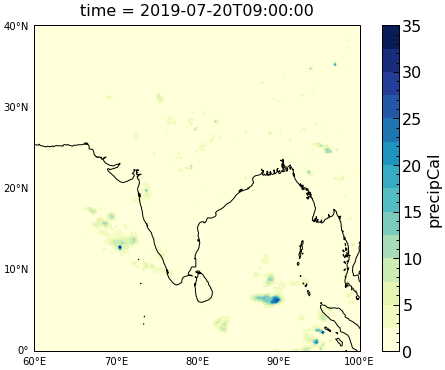

In [51]:
# fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([59.9, 100.1, -0.1, 40.1], crs=ccrs.PlateCarree())
ds_comb.precipCal.sel(time="2019-07-20 09:00:00").plot.contourf(ax = ax, extend='neither', levels=15)
ax.coastlines()
gridliner = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.05, linestyle='--')
# ax.add_feature(cfeature.BORDERS)
# ax.add_feature(cfeature.COASTLINE)
gridliner.top_labels = False
gridliner.right_labels = False
gridliner.ylines = False  # you need False
gridliner.xlines = False  # you need False
# ax.tick_params(axis='both', labelsize=12)

**Getting the the monsoon data from all years**

In [7]:
mon = [6,7,8,9]
premon = [3,4,5]
postmon = [10,11,12]
wint = [1,2]

In [8]:
ds_comb_mon = xr.concat([list(ds_comb.groupby('time.month'))[i][1] for i in mon], dim='time')

In [9]:
ds_comb_mon

<xarray.Dataset>
Dimensions:    (lon: 161, lat: 161, time: 8856)
Coordinates:
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2017-07-01 ... 2019-10-31T23:00:00
Data variables:
    precipCal  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    t2m        (time, lat, lon) float32 300.9 300.7 300.6 ... 274.6 274.8 274.4
    d2m        (time, lat, lon) float32 295.3 295.6 295.6 ... 265.7 264.6 266.6

**analysing**

In [10]:
precip = ds_comb_mon.precipCal
t2m = ds_comb_mon.t2m
d2m = ds_comb_mon.d2m

In [11]:
# precip_daily_rate = precip[::-1].rolling(time=24).sum()[::-1]

In [12]:
# Set values less than 1 mm/hr to nan

precip = precip.where(precip > 1)
t2m = t2m.where(precip != np.nan)
d2m = d2m.where(precip != np.nan)

In [13]:
ds_comb_new = xr.merge([precip, t2m, d2m]).chunk(dict(time=-1, lat=40, lon=40))
ds_comb_new

<xarray.Dataset>
Dimensions:    (lon: 161, lat: 161, time: 8856)
Coordinates:
  * lon        (lon) float64 60.0 60.25 60.5 60.75 ... 99.25 99.5 99.75 100.0
  * lat        (lat) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * time       (time) datetime64[ns] 2017-07-01 ... 2019-10-31T23:00:00
Data variables:
    precipCal  (time, lat, lon) float32 dask.array<chunksize=(8856, 40, 40), meta=np.ndarray>
    t2m        (time, lat, lon) float32 dask.array<chunksize=(8856, 40, 40), meta=np.ndarray>
    d2m        (time, lat, lon) float32 dask.array<chunksize=(8856, 40, 40), meta=np.ndarray>

In [14]:
ds_comb_new.unify_chunks()
ds_comb_new.chunks

Frozen({'time': (8856,), 'lat': (40, 40, 40, 40, 1), 'lon': (40, 40, 40, 40, 1)})

In [15]:
mum = ds_comb_new.sel(lat = 19.5, lon = 72.5)

In [16]:
mum.chunks

Frozen({'time': (8856,)})

In [17]:
binned_ds99 = binning.get_binned(mum, percentile_val=0.99, var = "t2m", bin_nr=10)

In [18]:
binned_ds50 = binning.get_binned(mum, percentile_val=0.50, var = "t2m", bin_nr=10)

In [19]:
binned_ds99

<xarray.Dataset>
Dimensions:    (t2m_bins: 10)
Coordinates:
  * t2m_bins   (t2m_bins) object (298.051, 299.581] ... (302.178, 304.428]
    quantile   float64 0.99
Data variables:
    precipCal  (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    t2m        (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    d2m        (t2m_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [20]:
temparr99, preciparr1_99, preciparr2_99 = ccplot.get_ideal_data(mum.t2m, 1, 10, time_scale=1)
temparr50, preciparr1_50, preciparr2_50 = ccplot.get_ideal_data(mum.t2m, 0.009, 0.09, time_scale=1)

In [21]:
temparr99, preciparr3_99, preciparr4_99 = ccplot.get_ideal_data(mum.t2m, 0.001, 2.5, time_scale=20)
temparr50, preciparr3_50, preciparr4_50 = ccplot.get_ideal_data(mum.t2m, 0.009, 0.09, time_scale=20)

In [22]:
binned_ds99 = binned_ds99.rename_vars({'precipCal':'precipitationCal'})
binned_ds50 = binned_ds50.rename_vars({'precipCal':'precipitationCal'})

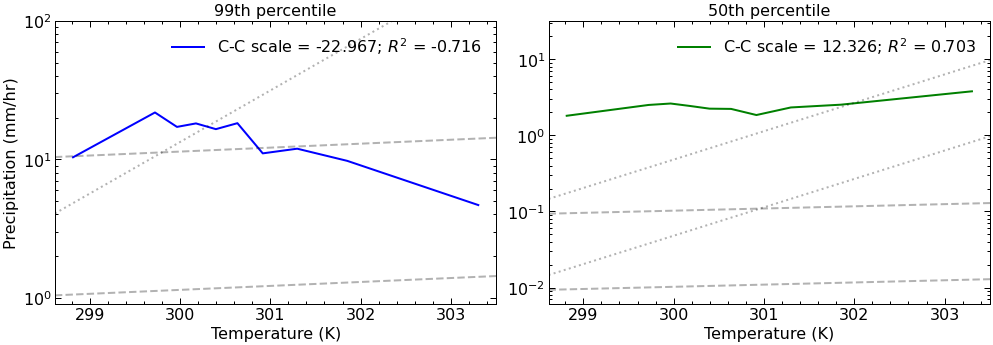

In [24]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, "t2m_bins", temparr99, preciparr1_99, preciparr2_99, preciparr3_99, preciparr4_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('99th percentile')
plt.ylim(0.9, 100)
plt.yticks([1, 10, 100])

# fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, "t2m_bins", temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
# plt.ylim(0.001, 1)
# plt.yticks([0.001, 0.01, 0.1, 1])

# fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot.pdf', dpi = 300)

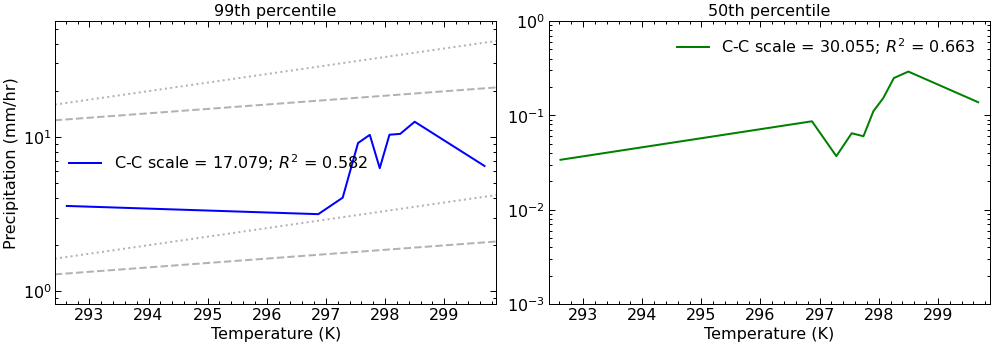

In [69]:
fig = plt.figure(figsize=(14,5))

plt.subplot(121)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds99, "d2m_bins", temparr99, preciparr1_99, preciparr2_99, preciparr3_99, preciparr4_99, fit=False, color = 'blue')
plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('99th percentile')

fig.gca().yaxis.set_ticks_position('both')

plt.subplot(122)
ccplot.plot(mum.chunk(dict(time=-1)), binned_ds50, "d2m_bins", temparr50, preciparr1_50, preciparr2_50, preciparr3_50, preciparr4_50, fit=False, color = 'green')

# plt.ylabel('Precipitation (mm/hr)')
plt.xlabel('Temperature (K)')
plt.title('50th percentile')
plt.ylim(0.001, 1)
plt.yticks([0.001, 0.01, 0.1, 1])

fig.gca().yaxis.set_ticks_position('both')
fig.tight_layout()
plt.savefig('./images/mumbai_ccplot_d2m.pdf', dpi = 300)